In [1]:
import numpy as np
import matplotlib.pyplot as plt
import keras
import tensorflow as tf
from scipy.stats import norm, skewnorm
%matplotlib inline

Using TensorFlow backend.


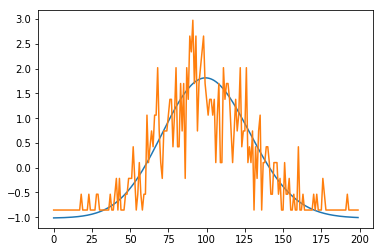

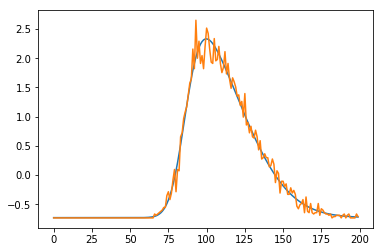

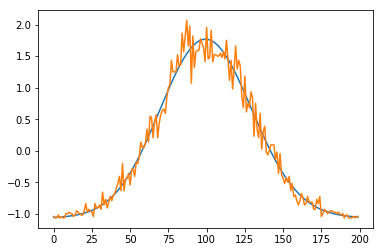

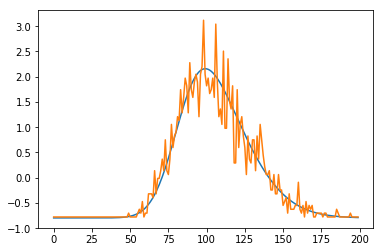

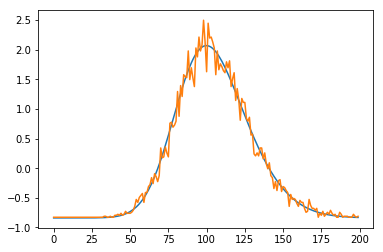

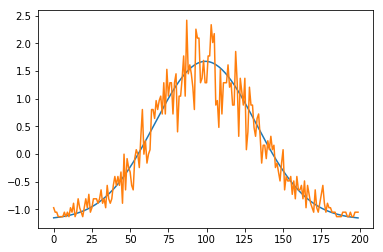

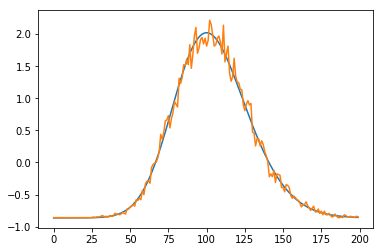

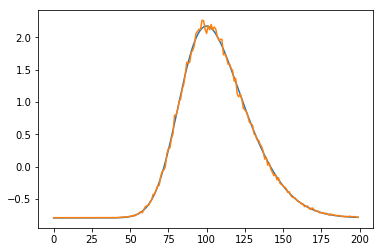

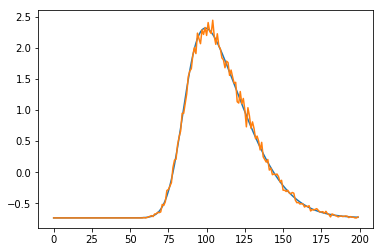

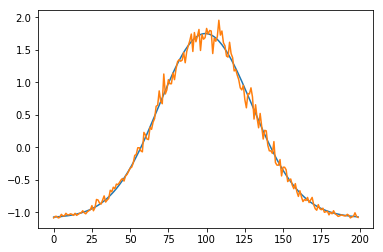

In [2]:
class PeakModel:
    @classmethod
    def spikenoise(cls, length, maxintensity):
        data = np.arange(length)
        print(data)
        return data
    @classmethod
    def peak(cls, maxcps, datapoints, dwelltime, skew = 0, sigma = 3, location = 0):
        location = 0
        scale = 1
        alpha = skew
#         delta = alpha / np.sqrt(1+alpha**2)
#         uz = np.sqrt(2/np.pi) * delta
#         sigmaz = np.sqrt(1.0-uz**2.0)
#         gamma = (4-np.pi)/2 * (delta*np.sqrt(2/np.pi))**3/(1-2*delta**2/np.pi)**(3/2)
#         moa = uz - (gamma * sigmaz / 2) - (np.sign(alpha))*np.exp(-2*np.pi/np.abs(alpha))
#         mode = location + scale * moa
#         _norm_ = skewnorm.pdf(x=mode, a=alpha, loc=location, scale=scale) # 標準正規分布の高さ

        times = np.linspace(-sigma, sigma, datapoints)                
        _refpeak_ = [skewnorm.pdf(x = time, a=alpha, loc=0, scale=scale) for time in times]
        _norm_ = np.max(_refpeak_)
        maxindex = np.argmax(_refpeak_)
        maxtime = times[maxindex]
        # refpeak = np.array(_refpeak_) * maxcps / _norm_
        refpeak = np.array([skewnorm.pdf(x=time, a=alpha, loc= location - maxtime, scale=scale) * maxcps / _norm_ for time in times])
        # print('maxindex:', maxindex)
        # print('maxpos:', maxtime)
        samplepeak = np.array([np.random.poisson(peak * dwelltime / 1000) * 1000 / dwelltime for peak in refpeak])
        return times, refpeak, samplepeak    
    @classmethod
    def baseline(cls, level, datapoints, dwelltime):
        sample = np.array([np.random.poisson(level * dwelltime / 1000) * 1000 / dwelltime for i in np.arange(datapoints)])
        variation = np.max(sample) - np.min(sample)
        
        return sample, variation
    @classmethod
    def spikenoise(cls, datapoints):
        sample = np.array([np.random.poisson(1) for i in np.arange(datapoints)])
        # print(sample)
        return sample
    @classmethod
    def zscore(cls, x, axis = None):
        xmean = np.mean(x, axis=axis, dtype='float')
        xstd  = np.std(x, axis=axis, keepdims=True)
        zscore = (x-xmean)/xstd
        return zscore
    @classmethod
    def chrom(cls, datapoints):
        baselinelevel = 10**(np.random.rand() * 5)
        skw = np.random.rand() * 5
        dt = np.random.randint(1,50)
        snr = 3 + np.random.rand() * 10 
        base, noiselevel = PeakModel.baseline(level= baselinelevel, datapoints= datapoints, dwelltime=dt)
        peakheight = np.max([noiselevel, 10]) * snr
        times, refpeak, samplepeak = PeakModel.peak(maxcps = peakheight, datapoints = datapoints, dwelltime = dt, skew=skw)
        sample_with_noise = samplepeak + base
        return samplepeak, refpeak
        
# noise = baselinenoise()
# PeakModel.spikenoise(10, 1)
for i in np.arange(10):
    samplepeak, refpeak = PeakModel.chrom(200)
    refpeak = PeakModel.zscore(refpeak)
    samplepeak = PeakModel.zscore(samplepeak)
    plt.plot(refpeak)
    plt.plot(samplepeak)
    plt.show()


In [3]:
class Generator(object):
    def __init__(self, batch_size, datapoints):
        self.batch_size = batch_size
        self.datapoints = datapoints
        
    def zscore(self, x, axis = None):
        xmean = np.mean(x, axis=axis, dtype='float')
        xstd  = np.std(x, axis=axis, keepdims=True)
        zscore = (x-xmean)/xstd
        return zscore

    def generate(self, train=True):
        """
        batchサイズ分のデータを作ってyieldし続けるgenerator
        """
        while True:
            # if train:
            #     pass
            # else:
            #     pass
            inputs = []
            outputs = []
            for _ in np.arange(self.batch_size):
                _input, _output = PeakModel.chrom(self.datapoints)
                _input = self.zscore(_input)
                _output = self.zscore(_output)
                inputs.append(_input)
                outputs.append(_output)
            yield np.array(inputs).reshape(-1,self.datapoints), np.array(outputs).reshape(-1,self.datapoints)


In [4]:
gen = Generator(batch_size=32, datapoints=1024)
g = gen.generate(train= True)
a, b = next(g)
a = np.array(a)
b = np.array(b)
print(a.shape)
print(b)

(32, 1024)
[[-0.84108877 -0.8410887  -0.84108864 ... -0.83300891 -0.8331744
  -0.83333676]
 [-1.09664463 -1.09632102 -1.09599139 ... -1.0919531  -1.0923389
  -1.09271809]
 [-0.99960475 -0.9995241  -0.99944137 ... -0.99066871 -0.99090632
  -0.99113955]
 ...
 [-0.76832861 -0.76832861 -0.76832861 ... -0.75944888 -0.75962803
  -0.75980386]
 [-0.76218131 -0.76218131 -0.76218131 ... -0.75319146 -0.75337253
  -0.75355025]
 [-1.11238335 -1.11200649 -1.11162291 ... -1.10855643 -1.10898162
  -1.10939968]]


In [5]:
from mschromnet import MSChromNet
input_shape = (1024, )
model = MSChromNet(input_shape)
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 1024)              0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 1024, 1)           0         
_________________________________________________________________
conv1_1 (Conv1D)             (None, 1024, 4)           16        
_________________________________________________________________
conv1_2 (Conv1D)             (None, 1024, 4)           52        
_________________________________________________________________
pool1 (MaxPooling1D)         (None, 512, 4)            0         
_________________________________________________________________
conv2_1 (Conv1D)             (None, 512, 8)            104       
_________________________________________________________________
conv2_2 (Conv1D)             (None, 512, 8)            200       
__________

In [6]:
def schedule(epoch, decay=0.9):
    return base_lr * decay**(epoch)

def mseloss(x, x_decoded):
    result = keras.backend.sum(keras.backend.square(x-x_decoded), keepdims=True) / 100
    print(result)
    return result

callbacks = [keras.callbacks.ModelCheckpoint('./weights.{epoch:02d}-{val_loss:.2f}.hdf5',
                                             verbose=1, save_best_only=True,
                                             save_weights_only=True),
             keras.callbacks.LearningRateScheduler(schedule)]

In [7]:
base_lr = 3e-4
momentum = 0.9
decay = 1e-6
sgd = keras.optimizers.SGD(lr=base_lr, decay=1e-6, momentum=momentum, nesterov=True)
adadelta = keras.optimizers.Adadelta(lr=1.0, rho=0.95, epsilon=None, decay=0.0)

model.compile(loss='mean_squared_error', optimizer='sgd')

In [ ]:
nb_epoch = 30
history = model.fit_generator(gen.generate(True), 100,
                              nb_epoch, verbose=1,
                              callbacks=callbacks,
                              validation_data=gen.generate(False),
                              nb_val_samples=10,
                              nb_worker=1)

c:\users\yoshi\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:7: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  import sys
c:\users\yoshi\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:7: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<generator..., 100, 30, verbose=1, callbacks=[<keras.ca..., validation_data=<generator..., validation_steps=10, workers=1)`
  import sys


Epoch 1/30
  4/100 [>.............................] - ETA: 38:33 - loss: 1.2500